# Neural Networks Implementation from Scratch

This notebook provides a comprehensive guide to implementing neural networks from scratch, visualizing the learning process, and comparing with PyTorch implementation.

## 1. Import Required Libraries

In this section, we'll import all necessary libraries for neural network implementation and visualization.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

# For reproducibility : to make sure your results are the same every time you run the code.
# ensures that NumPy operations behave predictably.
# ensures that PyTorch operations are also deterministic (as much as possible).
np.random.seed(42)
torch.manual_seed(42)

# Set up matplotlib for better visualizations
# plt.style.use('seaborn-whitegrid')

## 2. Data Preparation and Exploration

In this section, we'll load the MNIST dataset, explore its structure, and prepare it for neural network training.

- **It's a dataset of 70,000 images of handwritten digits (0–9).**
- **Each image is 28 x 28 pixels in grayscale → so total 784 pixels per image.**

In [50]:
# Load MNIST dataset
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Data type:", X.dtype)
print("Target type:", y.dtype)


Loading MNIST dataset...
X shape: (70000, 784)
y shape: (70000,)
Data type: int64
Target type: object


### Explore the Dataset

Let's visualize some samples from the MNIST dataset to understand what we're working with.

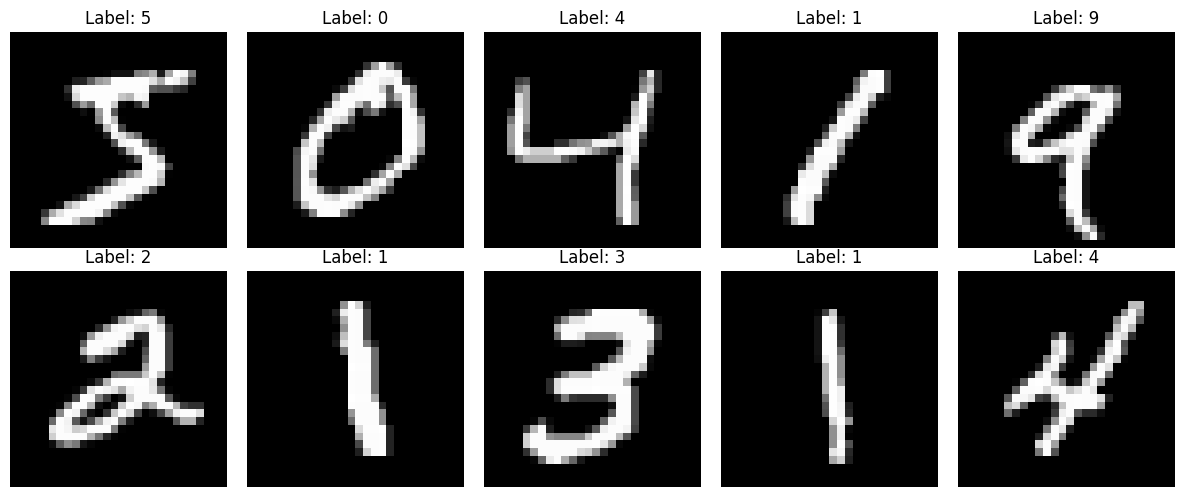

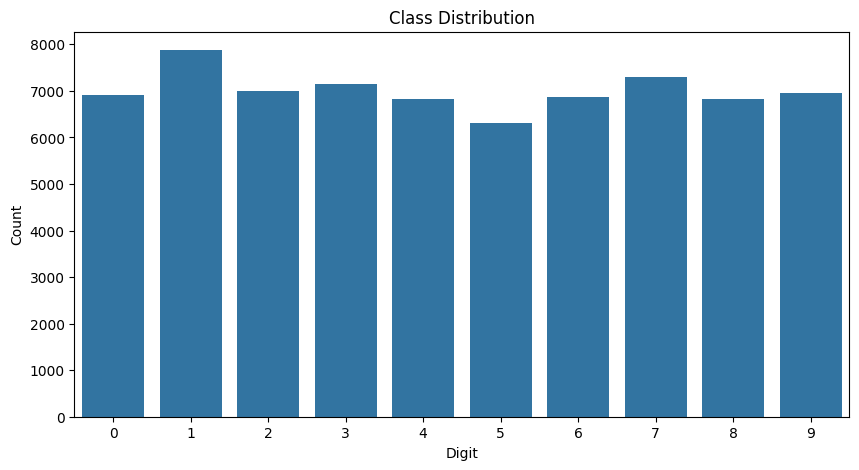

In [51]:
# Convert target to numeric
y = y.astype(int)

# Plot some examples
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Check class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

### Data Preparation

Now let's prepare our data:
1. Normalize the pixel values
2. Split into training and test sets
3. Convert labels to one-hot encoding for multi-class classification

In [52]:
# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to one-hot encoding
def to_one_hot(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    for i, val in enumerate(y):
        one_hot[i, val] = 1
    return one_hot
'''
    example pf one-hot encoding:
    y = [0, 1, 2, 3]
    one_hot = [[1, 0, 0, 0],  # 0
               [0, 1, 0, 0],  # 1
               [0, 0, 1, 0],  # 2
               [0, 0, 0, 1]]  # 3
'''

y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_one_hot.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test_one_hot.shape)


X_train shape: (56000, 784)
y_train shape: (56000, 10)
X_test shape: (14000, 784)
y_test shape: (14000, 10)


In [53]:

# Create a smaller subset for faster execution during development
def create_subset(X, y, n_samples):
    indices = np.random.choice(X.shape[0], n_samples, replace=False)
    return X[indices], y[indices]
'''
    example of create_subset:
    X = [[1, 2], [3, 4], [5, 6], [7, 8]]
    y = [[0, 1], [1, 0], [0, 1], [1, 0]]
    n_samples = 2
    create_subset(X, y, n_samples) will return:
    X_subset = [[1, 2], [5, 6]]
    y_subset = [[0, 1], [0, 1]]
    
'''

# Creating a development subset
n_subset = 10000
X_train_subset, y_train_subset = create_subset(X_train, y_train_one_hot, n_subset)
X_test_subset, y_test_subset = create_subset(X_test, y_test_one_hot, n_subset // 5)

# Further split the training subset into train and validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_subset, y_train_subset, test_size=0.2, random_state=42)

print("\nSubset for development:")
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test_subset shape:", X_test_subset.shape)
print("y_test_subset shape:", y_test_subset.shape)


Subset for development:
X_train_final shape: (8000, 784)
y_train_final shape: (8000, 10)
X_val shape: (2000, 784)
y_val shape: (2000, 10)
X_test_subset shape: (2000, 784)
y_test_subset shape: (2000, 10)


## 3. Neural Network Fundamentals

In this section, we'll implement the basic building blocks of neural networks:
- Activation functions
- Loss functions
- Neurons and layers

In [54]:
# Activation functions
def sigmoid(x):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

def sigmoid_derivative(x):
    """Derivative of sigmoid function"""
    sig_x = sigmoid(x)
    return sig_x * (1 - sig_x)

def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU function"""
    return (x > 0).astype(float)

def tanh(x):
    """Hyperbolic tangent activation function"""
    return np.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh function"""
    return 1 - np.tanh(x)**2

def softmax(x):
    """Softmax activation function for output layer"""
    # For numerical stability, subtract the max value
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss functions
def mse_loss(y_true, y_pred):
    """Mean squared error loss"""
    return np.mean(np.sum((y_true - y_pred)**2, axis=1))

def categorical_crossentropy_loss(y_true, y_pred):
    """Categorical cross-entropy loss"""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def binary_crossentropy_loss(y_true, y_pred):
    """Binary cross-entropy loss"""
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

### Visualizing Activation Functions

Let's visualize the activation functions and their derivatives to better understand their behavior.

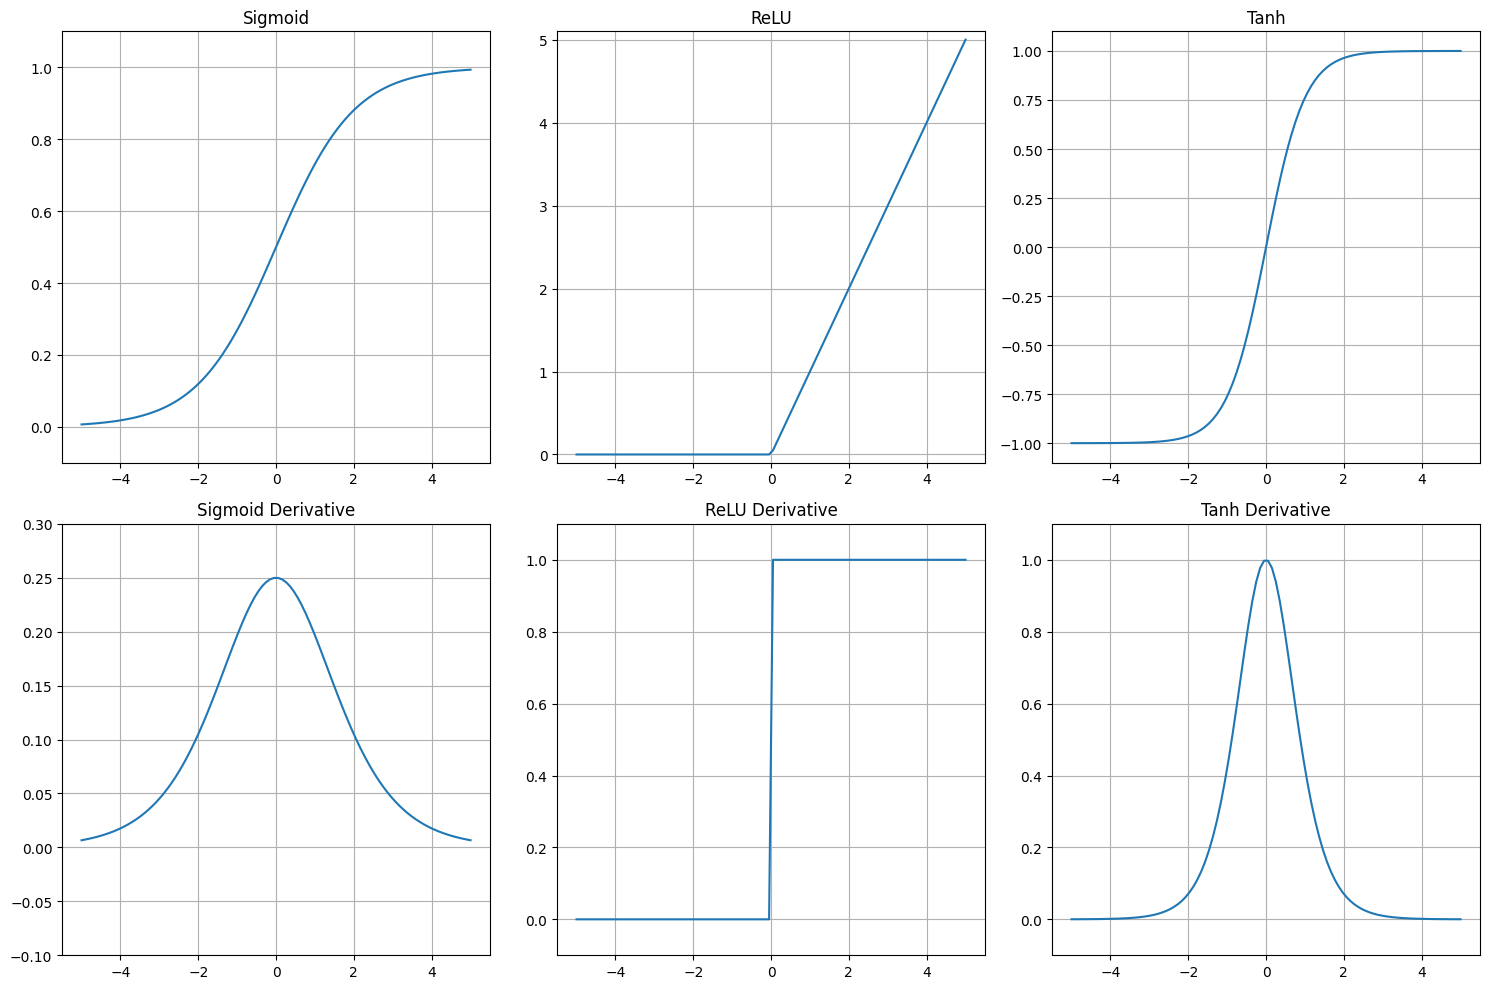

In [55]:
# Plot activation functions and their derivatives
x = np.linspace(-5, 5, 100)
'''
    np.linspace(-5, 5, 100) will return an array of 100 evenly spaced values between -5 and 5.
    [-5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0]
    It is useful for plotting functions or creating ranges of values.
'''
plt.figure(figsize=(15, 10))

# Plot activation functions
plt.subplot(2, 3, 1)
plt.plot(x, sigmoid(x))
plt.grid(True)
plt.title('Sigmoid')
plt.ylim(-0.1, 1.1)

plt.subplot(2, 3, 2)
plt.plot(x, relu(x))
plt.grid(True)
plt.title('ReLU')
plt.ylim(-0.1, 5.1)

plt.subplot(2, 3, 3)
plt.plot(x, tanh(x))
plt.grid(True)
plt.title('Tanh')
plt.ylim(-1.1, 1.1)

# Plot derivatives
plt.subplot(2, 3, 4)
plt.plot(x, sigmoid_derivative(x))
plt.grid(True)
plt.title('Sigmoid Derivative')
plt.ylim(-0.1, 0.3)

plt.subplot(2, 3, 5)
plt.plot(x, relu_derivative(x))
plt.grid(True)
plt.title('ReLU Derivative')
plt.ylim(-0.1, 1.1)

plt.subplot(2, 3, 6)
plt.plot(x, tanh_derivative(x))
plt.grid(True)
plt.title('Tanh Derivative')
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

## 4. Building Neural Network from Scratch

Now we'll create a modular neural network class with customizable architecture. Our network will consist of:
- Multiple layers with configurable sizes
- Support for different activation functions
- Methods for forward and backward propagation

In [56]:
class NeuralNetwork:
    """
    A fully-connected neural network implementation from scratch.
    """
    def __init__(self, layer_sizes, activations, learning_rate=0.01):
        """
        Initialize the neural network
        
        Parameters:
        -----------
        layer_sizes : list
            Sizes of each layer, including input and output layers
        activations : list
            Activation functions for each layer (except input layer)
        learning_rate : float
            Learning rate for gradient descent
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.learning_rate = learning_rate
        
        # Set activation functions
        self.activation_funcs = []
        self.activation_derivatives = []
        
        for activation in activations:
            if activation == 'sigmoid':
                self.activation_funcs.append(sigmoid)
                self.activation_derivatives.append(sigmoid_derivative)
            elif activation == 'relu':
                self.activation_funcs.append(relu)
                self.activation_derivatives.append(relu_derivative)
            elif activation == 'tanh':
                self.activation_funcs.append(tanh)
                self.activation_derivatives.append(tanh_derivative)
            elif activation == 'softmax':
                self.activation_funcs.append(softmax)
                # Softmax derivative is handled specially during backpropagation
                self.activation_derivatives.append(None)
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        self.initialize_parameters()
        
        # For storing intermediate values during forward propagation
        self.z_values = []  # Pre-activation values
        self.activations = []  # Post-activation values
        
        # For storing training history
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        
    def initialize_parameters(self):
        """Initialize weights and biases with random values"""
        for i in range(1, self.num_layers):
            # initialization for weights
            scale = np.sqrt(2.0 / self.layer_sizes[i-1])
            self.weights.append(np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * scale)
            self.biases.append(np.zeros((1, self.layer_sizes[i])))
            """
            example of weights and biases initialization:
            we have 4 layers:
            layer_sizes = [784, 128, 64, 10]
            weights[0] = np.random.randn(784, 128) * np.sqrt(2.0 / 784)
            biases[0] = np.zeros((1, 128))
            weights[1] = np.random.randn(128, 64) * np.sqrt(2.0 / 128)
            biases[1] = np.zeros((1, 64))
            weights[2] = np.random.randn(64, 10) * np.sqrt(2.0 / 64)
            biases[2] = np.zeros((1, 10))


            """

    
    def get_parameters(self):
        """Return all weights and biases"""
        return self.weights, self.biases
    
    def set_parameters(self, weights, biases):
        """Set weights and biases"""
        self.weights = weights
        self.biases = biases
        
    def save_model(self, filename):
        """Save model parameters to a file"""
        model_data = {
            'layer_sizes': self.layer_sizes,
            'weights': self.weights,
            'biases': self.biases
        }
        np.save(filename, model_data)
        print(f"Model saved to {filename}")
    
    def load_model(self, filename):
        """Load model parameters from a file"""
        model_data = np.load(filename, allow_pickle=True).item()
        self.layer_sizes = model_data['layer_sizes']
        self.weights = model_data['weights']
        self.biases = model_data['biases']
        self.num_layers = len(self.layer_sizes)
        print(f"Model loaded successfully from {filename}")

## 5. Forward Propagation Implementation

Now we'll implement the forward pass that processes inputs through the network layers to generate predictions.

In [57]:
def forward_propagation(self, X):
    """
    Perform forward propagation through the network
    
    Parameters:
    -----------
    X : ndarray
        Input data with shape (n_samples, n_features)
    
    Returns:
    --------
    ndarray
        Output predictions with shape (n_samples, n_outputs)
    """
    self.z_values = []
    self.activations = [X]  # First activation is the input
    
    for i in range(self.num_layers - 1):
        # Linear transformation
        z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
        '''
        example of dot product:
            activations[-1] = [[1, 2], [3, 4]]
            weights[i] = [[5, 6], [7, 8]]
        '''

        self.z_values.append(z)
        
        # Apply activation function
        a = self.activation_funcs[i](z)
        self.activations.append(a)
    
    return self.activations[-1]  # Return the output layer's activation

# Add the method to the NeuralNetwork class
NeuralNetwork.forward_propagation = forward_propagation

### Visualizing the Forward Propagation

Let's implement a function to visualize activations at different layers during forward propagation.

In [58]:
def visualize_activations(self, X_sample):
    """
    Visualize the activations at each layer for a single input sample
    
    Parameters:
    -----------
    X_sample : ndarray
        A single input sample
    """
    # Perform forward pass
    self.forward_propagation(X_sample.reshape(1, -1))
    
    fig = plt.figure(figsize=(15, 10))
    
    # Plot input image
    plt.subplot(2, 3, 1)
    plt.imshow(X_sample.reshape(28, 28), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot activations for each hidden layer
    for i in range(1, min(5, len(self.activations))):
        plt.subplot(2, 3, i+1)
        activations = self.activations[i]
        
        # For visualizing activations
        if i < len(self.activations) - 1:  # For hidden layers
            plt.hist(activations.flatten(), bins=30, alpha=0.7)
            plt.title(f'Layer {i} Activation Distribution')
            plt.xlabel('Activation Value')
            plt.ylabel('Frequency')
        else:  # For output layer
            plt.bar(np.arange(len(activations[0])), activations[0])
            plt.xticks(np.arange(len(activations[0])))
            plt.title('Output Layer (Probability per class)')
            plt.xlabel('Class')
            plt.ylabel('Probability')
    
    # Plot highest activations in the last hidden layer if available
    if len(self.activations) > 2:
        plt.subplot(2, 3, 6)
        last_hidden = self.activations[-2][0]
        # Get indices of highest activations
        top_indices = np.argsort(last_hidden)[-20:]
        plt.bar(np.arange(len(top_indices)), last_hidden[top_indices])
        plt.title('Top 20 Activations in Last Hidden Layer')
        plt.xlabel('Neuron Index (sorted)')
        plt.ylabel('Activation Value')
    
    plt.tight_layout()
    plt.show()

# Add the method to the NeuralNetwork class
NeuralNetwork.visualize_activations = visualize_activations

## 6. Backward Propagation Implementation

Now we'll implement the backpropagation algorithm to calculate gradients of the loss function with respect to weights and biases.

### **Backpropagation Equations**

#### 1. Output layer error (Softmax + CrossEntropy):
$$
\delta^{(L)} = a^{(L)} - y
$$

#### 2. Output layer error (other activations like sigmoid or ReLU):
$$
\delta^{(L)} = (a^{(L)} - y) \cdot f'(z^{(L)})
$$

#### 3. Gradient of weights and biases (Output layer):
$$
\frac{\partial \mathcal{L}}{\partial W^{(L)}} = \frac{1}{m} \cdot (a^{(L-1)})^T \cdot \delta^{(L)}
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{(L)}} = \frac{1}{m} \cdot \sum \delta^{(L)}
$$

#### 4. Hidden layer error:
$$
\delta^{(l)} = \left( \delta^{(l+1)} \cdot (W^{(l+1)})^T \right) \cdot f'(z^{(l)})
$$

#### 5. Gradient of weights and biases (Hidden layers):
$$
\frac{\partial \mathcal{L}}{\partial W^{(l)}} = \frac{1}{m} \cdot (a^{(l-1)})^T \cdot \delta^{(l)}
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{(l)}} = \frac{1}{m} \cdot \sum \delta^{(l)}
$$



### 📘 Notation Used

- **m**: Number of training samples  
- **a^(l)**: Activation output from layer l  
- **z^(l)**: Pre-activation value at layer l (before applying activation function)  
- **W^(l)**: Weight matrix for layer l  
- **b^(l)**: Bias vector for layer l  
- **δ^(l)**: Error term (gradient of loss) at layer l  
- **L**: Loss function  
- **y**: True labels  
- **a^(L)**: Output of the final (last) layer (predicted values)


---

### 🎯 Step 1: Output Error

#### Case 1: Softmax + Cross-Entropy (simplified derivative)
$$
\delta^{(L)} = a^{(L)} - y
$$

#### Case 2: Other Activations
$$
\delta^{(L)} = (a^{(L)} - y) \cdot f'\left(z^{(L)}\right)
$$

---

### 🔧 Step 2: Gradients for Output Layer

#### Weights:
$$
\frac{\partial \mathcal{L}}{\partial W^{(L)}} = \frac{1}{m} \cdot (a^{(L-1)})^T \cdot \delta^{(L)}
$$

#### Biases:
$$
\frac{\partial \mathcal{L}}{\partial b^{(L)}} = \frac{1}{m} \cdot \sum_{i=1}^{m} \delta^{(L)}_i
$$

---

### 🔁 Step 3: Backpropagate to Hidden Layers

For each hidden layer \( l = L-1, L-2, ..., 1 \):

#### Error term:
$$
\delta^{(l)} = \left( \delta^{(l+1)} \cdot (W^{(l+1)})^T \right) \cdot f'\left(z^{(l)}\right)
$$

#### Weights:
$$
\frac{\partial \mathcal{L}}{\partial W^{(l)}} = \frac{1}{m} \cdot (a^{(l-1)})^T \cdot \delta^{(l)}
$$

#### Biases:
$$
\frac{\partial \mathcal{L}}{\partial b^{(l)}} = \frac{1}{m} \cdot \sum_{i=1}^{m} \delta^{(l)}_i
$$



### ✅ These are the general gradient formulas:

$$
\frac{\partial \mathcal{L}}{\partial W^{[l]}} = \frac{1}{m} (A^{[l-1]})^T \cdot \delta^{[l]}
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{[l]}} = \frac{1}{m} \sum \delta^{[l]} \quad \text{(across samples)}
$$

Which in code looks like:

```python
weight_gradients[l] = np.dot(activations[l-1].T, delta) / m
bias_gradients[l] = np.sum(delta, axis=0, keepdims=True) / m
```

These are **always valid**, because they come from **the chain rule** in calculus.

But the **delta** is where the loss function and activation function *kick in*.

---

###  What changes is `delta` (error term):

* For **Softmax + Cross Entropy**:

  $$
  \delta^{[L]} = a^{[L]} - y
  $$
* For **Sigmoid + MSE**:

  $$
  \delta^{[L]} = (a^{[L]} - y) \cdot \sigma'(z^{[L]})
  $$
* For **any hidden layer**:

  $$
  \delta^{[l]} = (\delta^{[l+1]} \cdot (W^{[l+1]})^T) \cdot f'(z^{[l]})
  $$


In [59]:
def backward_propagation(self, y_true):
    """
    Perform backward propagation to update weights and biases
    
    Parameters:
    -----------
    y_true : ndarray
        True labels with shape (n_samples, n_outputs)
    
    Returns:
    --------
    tuple
        Gradients for weights and biases
    """
    m = y_true.shape[0]  # Number of samples
    
    # Initialize gradients
    '''
    example of weight_gradients initialization:
    weights = [w1, w2, w3]
    weight_gradients = [np.zeros_like(w1), np.zeros_like(w2), np.zeros_like(w3)]
    zeros_like(w) will return an array of zeros with the same shape as w.
    For example, if w1 is of shape (784, 128), weight_gradients[0] will be of shape (784, 128).
    '''
    weight_gradients = [np.zeros_like(w) for w in self.weights]
    bias_gradients = [np.zeros_like(b) for b in self.biases]
    






    # Output layer error
    y_pred = self.activations[-1]
    '''
    delte is the error term
     '''
    if self.activation_funcs[-1].__name__ == 'softmax':
        # Derivative of softmax with categorical cross-entropy is simplified
        delta = y_pred - y_true
    else:
        # For other activation functions
        delta = (y_pred - y_true) * self.activation_derivatives[-1](self.z_values[-1])
    
    # Output layer gradients
    weight_gradients[-1] = np.dot(self.activations[-2].T, delta) / m
    bias_gradients[-1] = np.sum(delta, axis=0, keepdims=True) / m
    
    # Backpropagate the error
    for l in range(2, self.num_layers):
        delta = np.dot(delta, self.weights[-l+1].T) * self.activation_derivatives[-l](self.z_values[-l])
        weight_gradients[-l] = np.dot(self.activations[-l-1].T, delta) / m
        bias_gradients[-l] = np.sum(delta, axis=0, keepdims=True) / m
    
    return weight_gradients, bias_gradients

# Add the method to the NeuralNetwork class
NeuralNetwork.backward_propagation = backward_propagation

### Visualizing Gradient Flow

Let's implement a function to visualize the gradient flow during backpropagation.

In [60]:
def visualize_gradients(self, X_batch, y_batch):
    """
    Visualize gradients for a batch of data
    
    Parameters:
    -----------
    X_batch : ndarray
        Input data batch
    y_batch : ndarray
        True labels batch
    """
    # Forward pass
    self.forward_propagation(X_batch)
    
    # Backward pass
    weight_gradients, bias_gradients = self.backward_propagation(y_batch)
    
    # Visualize weight gradients
    plt.figure(figsize=(15, 5 * ((len(weight_gradients) + 1) // 2)))
    
    for i, grad in enumerate(weight_gradients):
        plt.subplot((len(weight_gradients) + 1) // 2, 2, i + 1)
        plt.hist(grad.flatten(), bins=50, alpha=0.7)
        plt.title(f'Layer {i+1} Weight Gradients')
        plt.xlabel('Gradient Value')
        plt.ylabel('Frequency')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return gradients for further analysis if needed
    return weight_gradients, bias_gradients

# Add the method to the NeuralNetwork class
NeuralNetwork.visualize_gradients = visualize_gradients

### Updating Weights and Biases

Now let's implement the function to update weights and biases using the computed gradients.

In [61]:
def update_parameters(self, weight_gradients, bias_gradients):
    """
    Update weights and biases using computed gradients
    
    Parameters:
    -----------
    weight_gradients : list
        Gradients for weights
    bias_gradients : list
        Gradients for biases
    """
    for i in range(len(self.weights)):
        self.weights[i] -= self.learning_rate * weight_gradients[i]
        self.biases[i] -= self.learning_rate * bias_gradients[i]

# Add the method to the NeuralNetwork class
NeuralNetwork.update_parameters = update_parameters

## 7. Training the Neural Network

Now we'll implement the training process including:
- Mini-batch gradient descent
- Learning rate scheduling
- Early stopping

In [62]:
def train(self, X, y, epochs=50, batch_size=32, validation_data=None, 
          early_stopping_patience=5, learning_rate_decay=0.99, verbose=True):
    """
    Train the neural network using mini-batch gradient descent
    
    Parameters:
    -----------
    X : ndarray
        Training data with shape (n_samples, n_features)
    y : ndarray
        Training labels with shape (n_samples, n_outputs)
    epochs : int
        Number of training epochs
    batch_size : int
        Size of mini-batches
    validation_data : tuple
        (X_val, y_val) for validation
    early_stopping_patience : int
        Number of epochs to wait before early stopping
    learning_rate_decay : float
        Factor to decay learning rate each epoch
    verbose : bool
        Whether to print progress
    
    Returns:
    --------
    dict
        Training history
    """
    n_samples = X.shape[0]
    self.loss_history = []
    self.accuracy_history = []
    self.val_loss_history = []
    self.val_accuracy_history = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights, best_biases = None, None
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_loss = 0
        epoch_accuracy = 0
        
        # Process mini-batches
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward propagation
            y_pred = self.forward_propagation(X_batch)
            
            # Compute batch loss
            batch_loss = categorical_crossentropy_loss(y_batch, y_pred)
            epoch_loss += batch_loss * X_batch.shape[0] # we multiply by batch size to get the total loss for the epoch
            
            
            # Compute batch accuracy
            batch_accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
            epoch_accuracy += batch_accuracy * X_batch.shape[0]
            
            # Backward propagation
            weight_gradients, bias_gradients = self.backward_propagation(y_batch)
            
            # Update parameters
            self.update_parameters(weight_gradients, bias_gradients)
        
        # Calculate average epoch loss and accuracy
        epoch_loss /= n_samples
        epoch_accuracy /= n_samples
        
        # Store training metrics
        self.loss_history.append(epoch_loss)
        self.accuracy_history.append(epoch_accuracy)
        
        # Validation metrics
        if validation_data is not None:
            X_val, y_val = validation_data
            y_val_pred = self.forward_propagation(X_val)
            val_loss = categorical_crossentropy_loss(y_val, y_val_pred)
            val_accuracy = np.mean(np.argmax(y_val_pred, axis=1) == np.argmax(y_val, axis=1))
            
            self.val_loss_history.append(val_loss)
            self.val_accuracy_history.append(val_accuracy)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model parameters
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
            else:
                patience_counter += 1
                
            if patience_counter >= early_stopping_patience:
                if verbose:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                # Restore best parameters
                self.weights = best_weights
                self.biases = best_biases
                break
                
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - accuracy: {epoch_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
        else:
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - accuracy: {epoch_accuracy:.4f}")
        
        # Learning rate decay
        self.learning_rate *= learning_rate_decay
    
    history = {
        'loss': self.loss_history,
        'accuracy': self.accuracy_history,
        'val_loss': self.val_loss_history,
        'val_accuracy': self.val_accuracy_history
    }
    
    return history

# Add the method to the NeuralNetwork class
NeuralNetwork.train = train

### Making Predictions

Let's implement methods for making predictions with our trained model.

In [63]:
def predict(self, X):
    """
    Make predictions for input data
    
    Parameters:
    -----------
    X : ndarray
        Input data with shape (n_samples, n_features)
    
    Returns:
    --------
    ndarray
        Predicted class probabilities
    """
    return self.forward_propagation(X)

def predict_classes(self, X):
    """
    Predict class labels for input data
    
    Parameters:
    -----------
    X : ndarray
        Input data with shape (n_samples, n_features)
    
    Returns:
    --------
    ndarray
        Predicted class labels
    """
    probabilities = self.predict(X)
    return np.argmax(probabilities, axis=1)

# Add the methods to the NeuralNetwork class
NeuralNetwork.predict = predict
NeuralNetwork.predict_classes = predict_classes

## 8. Visualization of Learning Process

Let's create functions to visualize the training process:
- Loss and accuracy curves
- Weight distribution
- Decision boundaries

In [64]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    Parameters:
    -----------
    history : dict
        Training history from the train method
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history and history['val_accuracy']:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_weight_distribution(self):
    """
    Plot the distribution of weights in each layer
    """
    num_layers = len(self.weights)
    plt.figure(figsize=(15, 4 * ((num_layers + 1) // 2)))
    
    for i, weights in enumerate(self.weights):
        plt.subplot((num_layers + 1) // 2, 2, i + 1)
        plt.hist(weights.flatten(), bins=50, alpha=0.7)
        plt.title(f'Layer {i+1} Weight Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Add the method to the NeuralNetwork class
NeuralNetwork.plot_weight_distribution = plot_weight_distribution

def visualize_decision_boundary(model, X, y, feature1=0, feature2=1, resolution=100):
    """
    Visualize decision boundary for a 2D feature space
    
    Parameters:
    -----------
    model : NeuralNetwork
        Trained neural network model
    X : ndarray
        Input data
    y : ndarray
        True labels
    feature1 : int
        Index of the first feature to use
    feature2 : int
        Index of the second feature to use
    resolution : int
        Number of points to sample in each dimension
    """
    # Use PCA to reduce to 2D if more than 2 dimensions
    if X.shape[1] > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
    else:
        X_2d = X
    
    # Create a mesh grid
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    
    # Prepare data points for prediction
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    if X.shape[1] > 2:
        # Project grid points back to original space
        # This is approximate and might not work well for all cases
        grid_orig = pca.inverse_transform(grid_points)
        Z = model.predict_classes(grid_orig)
    else:
        Z = model.predict_classes(grid_points)
    
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.viridis)
    
    # Plot the training points
    actual_classes = np.argmax(y, axis=1) if len(y.shape) > 1 else y
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=actual_classes, 
                edgecolors='k', alpha=0.7)
    
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title('Decision Boundary (PCA projection if dim > 2)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Predicted class')
    plt.tight_layout()
    plt.show()

### Learning Rate Animation

Let's create an animation to see how different learning rates affect training.

In [65]:
def visualize_learning_rate_effect(X, y, X_val, y_val, layer_sizes, activations, 
                                 learning_rates=[0.1, 0.01, 0.001]):
    """
    Visualize the effect of different learning rates on training
    
    Parameters:
    -----------
    X : ndarray
        Training data
    y : ndarray
        Training labels
    X_val : ndarray
        Validation data
    y_val : ndarray
        Validation labels
    layer_sizes : list
        Network architecture
    activations : list
        Activation functions
    learning_rates : list
        Learning rates to compare
    """
    plt.figure(figsize=(15, 10))
    
    for i, lr in enumerate(learning_rates):
        # Train model with this learning rate
        model = NeuralNetwork(layer_sizes, activations, learning_rate=lr)
        history = model.train(X, y, epochs=20, batch_size=32, 
                            validation_data=(X_val, y_val), verbose=False)
        
        # Plot loss
        plt.subplot(2, len(learning_rates), i+1)
        plt.plot(history['loss'], label='Training')
        plt.plot(history['val_loss'], label='Validation')
        plt.title(f'Loss with LR = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot accuracy
        plt.subplot(2, len(learning_rates), i+1+len(learning_rates))
        plt.plot(history['accuracy'], label='Training')
        plt.plot(history['val_accuracy'], label='Validation')
        plt.title(f'Accuracy with LR = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 9. Model Evaluation

Now let's create functions to evaluate our trained model on test data and analyze its performance.

In [66]:
def evaluate(self, X, y):
    """
    Evaluate the model on test data
    
    Parameters:
    -----------
    X : ndarray
        Test data with shape (n_samples, n_features)
    y : ndarray
        Test labels with shape (n_samples, n_outputs)
    
    Returns:
    --------
    tuple
        (loss, accuracy)
    """
    y_pred = self.predict(X)
    loss = categorical_crossentropy_loss(y, y_pred)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
    return loss, accuracy

# Add the method to the NeuralNetwork class
NeuralNetwork.evaluate = evaluate

def plot_confusion_matrix(model, X, y_true):
    """
    Plot confusion matrix for model predictions
    
    Parameters:
    -----------
    model : NeuralNetwork
        Trained neural network model
    X : ndarray
        Input data with shape (n_samples, n_features)
    y_true : ndarray
        True labels with shape (n_samples, n_outputs)
    """
    from sklearn.metrics import confusion_matrix
    
    # Get predictions
    y_pred = model.predict_classes(X)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def analyze_misclassifications(self, X, y_true, n_samples=10):
    """
    Analyze and visualize misclassified examples
    
    Parameters:
    -----------
    X : ndarray
        Input data with shape (n_samples, n_features)
    y_true : ndarray
        True labels with shape (n_samples, n_outputs)
    n_samples : int
        Number of misclassified samples to show
    """
    # Get predictions
    y_pred = self.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Find misclassified examples
    misclassified = np.where(y_pred_classes != y_true_classes)[0]
    
    if len(misclassified) == 0:
        print("No misclassified examples found!")
        return
    
    # Select random misclassified examples
    selected = np.random.choice(misclassified, min(n_samples, len(misclassified)), replace=False)
    
    # Plot the examples
    n_cols = 5
    n_rows = (len(selected) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i, idx in enumerate(selected):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Assume images for visualization
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true_classes[idx]}, Pred: {y_pred_classes[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Add the method to the NeuralNetwork class
NeuralNetwork.analyze_misclassifications = analyze_misclassifications

## 10. Using PyTorch Implementation

Now let's implement the same neural network architecture using PyTorch.



### 🔹 1. **What is a Tensor?**

A **tensor** in PyTorch is basically a **generalized array** — it can be:

* A **scalar** (0D tensor): `torch.tensor(5)`
* A **vector** (1D tensor): `torch.tensor([1, 2, 3])`
* A **matrix** (2D tensor): `torch.tensor([[1, 2], [3, 4]])`
* Or higher-dimensional (3D, 4D...) — often used for images, sequences, batches.

> 🔧 It's like a NumPy array but optimized to work with **GPUs**, **autograd**, and **deep learning**.

---

### 🔹 2. **What is a TensorDataset?**

```python
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
```

This wraps your inputs **and** labels **together** into one dataset object.

So now:

* `train_dataset[i]` returns a tuple: `(X_train_tensor[i], y_train_tensor[i])`

This makes it super clean to use with data loaders for training.

---

### 🔹 3. **What is a DataLoader?**

```python
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
```

`DataLoader` is PyTorch’s way to:

* Load data in **mini-batches**
* **Shuffle** the data (to avoid overfitting to order)
* Iterate through it easily using `for x, y in train_loader:`

> So it's like giving your model **small bites of the data** instead of all at once.

---


| Concept         | What it is                                           |
| --------------- | ---------------------------------------------------- |
| `Tensor`        | Multi-dimensional array (like NumPy array)           |
| `TensorDataset` | Wraps (X, y) tensors together as one dataset         |
| `DataLoader`    | Makes it easy to loop over data in batches & shuffle |





### 🔹 `model.eval()`

This switches the model to **evaluation mode**.

✅ Why? Because during evaluation:

* Some layers like **Dropout** and **BatchNorm** behave differently.
* In training: Dropout randomly zeroes some neurons.
* In eval: Dropout is disabled (uses full network).

> So `model.eval()` tells the model: **"Yo, we're testing now, not training!"**

---

### 🔹 `with torch.no_grad():`

This disables **autograd (gradient tracking)**.

✅ Why? Because:

* During validation/testing, we **don’t want gradients**, just predictions.
* It saves **memory** and **speeds up** the computations.

> Think of it as: "I'm just passing data through, no learning here."

---

### 💡 TL;DR

| Code                    | Purpose                                   |
| ----------------------- | ----------------------------------------- |
| `model.eval()`          | Sets model to **evaluation mode**         |
| `with torch.no_grad():` | Disables gradient tracking to save memory |


In [ ]:
class PyTorchNN(nn.Module):
    """PyTorch implementation of the same neural network architecture"""
    def __init__(self, layer_sizes, activations):
        super(PyTorchNN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Create layers based on architecture
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            
        # Store activation function names
        self.activation_names = activations
        
    def forward(self, x):
        """Forward pass through the network"""
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            # Apply activation function
            if i < len(self.layers) - 1:  # Hidden layers
                if self.activation_names[i] == 'relu':
                    x = torch.relu(x)
                elif self.activation_names[i] == 'sigmoid':
                    x = torch.sigmoid(x)
                elif self.activation_names[i] == 'tanh':
                    x = torch.tanh(x)
            else:  # Output layer
                if self.activation_names[i] == 'softmax':
                    x = torch.softmax(x, dim=1)
        
        return x
    
def train_pytorch_model(X_train, y_train, X_val, y_val, layer_sizes, activations, 
                        epochs=20, batch_size=32, learning_rate=0.01):
    """
    Train a PyTorch model with the same architecture
    
    Parameters:
    -----------
    X_train : ndarray
        Training data
    y_train : ndarray
        Training labels
    X_val : ndarray
        Validation data
    y_val : ndarray
        Validation labels
    layer_sizes : list
        List defining the network architecture
    activations : list
        List of activation functions
    epochs : int
        Number of training epochs
    batch_size : int
        Mini-batch size
    learning_rate : float
        Learning rate for optimizer
        
    Returns:
    --------
    tuple
        (trained_model, history, training_time)
    """
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = PyTorchNN(layer_sizes, activations)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss() if activations[-1] == 'softmax' else nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 5
    
    # For learning rate scheduling
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    # History tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Time training
    start_time = time.time()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            '''
                train loader will return a batch of inputs and targets.
                inputs: shape (batch_size, n_features)
                targets: shape (batch_size, n_outputs)
                targets will be one-hot encoded for categorical cross-entropy loss.
                For example, if we have 3 classes and the target is class 1, it will be [0, 1, 0].
            '''
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, targets_idx = torch.max(targets, 1)
            correct += (predicted == targets_idx).sum().item()
            total += targets.size(0)
        
        # Average training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation metrics
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            _, val_predicted = torch.max(val_outputs, 1)
            _, val_targets = torch.max(y_val_tensor, 1)
            val_acc = (val_predicted == val_targets).sum().item() / val_targets.size(0)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # Restore best model
            break
            
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return model, history, training_time

## 11. Comparing Custom vs PyTorch Implementation

Let's compare our custom implementation with the PyTorch implementation in terms of:
- Performance (accuracy)
- Training time
- Learning curves

In [68]:
# Function to compare custom and PyTorch implementations
def compare_implementations(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Compare custom neural network with PyTorch implementation
    
    Parameters:
    -----------
    X_train : ndarray
        Training data
    y_train : ndarray
        Training labels
    X_val : ndarray
        Validation data
    y_val : ndarray
        Validation labels
    X_test : ndarray
        Test data
    y_test : ndarray
        Test labels
    """
    # Define network architecture
    input_dim = X_train.shape[1]
    hidden_layers = [128, 64]
    output_dim = y_train.shape[1]
    layer_sizes = [input_dim] + hidden_layers + [output_dim]
    activations = ['relu', 'relu', 'softmax']
    
    # Create and train custom model
    print("Training custom neural network...")
    custom_model = NeuralNetwork(layer_sizes, activations, learning_rate=0.01)
    
    custom_start_time = time.time()
    custom_history = custom_model.train(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        early_stopping_patience=5
    )
    custom_training_time = time.time() - custom_start_time
    
    # Create and train PyTorch model
    print("\nTraining PyTorch neural network...")
    pytorch_model, pytorch_history, pytorch_training_time = train_pytorch_model(
        X_train, y_train, X_val, y_val, 
        layer_sizes, activations, 
        epochs=20, batch_size=32, learning_rate=0.01
    )
    
    # Evaluate custom model
    custom_loss, custom_accuracy = custom_model.evaluate(X_test, y_test)
    
    # Evaluate PyTorch model
    pytorch_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test)
        outputs = pytorch_model(X_test_tensor)
        criterion = nn.CrossEntropyLoss()
        pytorch_loss = criterion(outputs, y_test_tensor).item()
        _, predicted = torch.max(outputs, 1)
        _, targets = torch.max(y_test_tensor, 1)
        pytorch_accuracy = (predicted == targets).sum().item() / targets.size(0)
    
    # Print comparison
    print("\n--- Performance Comparison ---")
    print(f"Custom Model - Test Accuracy: {custom_accuracy:.4f}, Training Time: {custom_training_time:.2f} seconds")
    print(f"PyTorch Model - Test Accuracy: {pytorch_accuracy:.4f}, Training Time: {pytorch_training_time:.2f} seconds")
    print(f"Speed-up with PyTorch: {custom_training_time / pytorch_training_time:.2f}x")
    
    # Plot training history comparison
    plt.figure(figsize=(15, 6))
    
    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(custom_history['accuracy'], label='Custom - Training')
    plt.plot(custom_history['val_accuracy'], label='Custom - Validation')
    plt.plot(pytorch_history['train_acc'], label='PyTorch - Training')
    plt.plot(pytorch_history['val_acc'], label='PyTorch - Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot training loss
    plt.subplot(1, 2, 2)
    plt.plot(custom_history['loss'], label='Custom - Training')
    plt.plot(custom_history['val_loss'], label='Custom - Validation')
    plt.plot(pytorch_history['train_loss'], label='PyTorch - Training')
    plt.plot(pytorch_history['val_loss'], label='PyTorch - Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return custom_model, pytorch_model

## Let's Run the Full Pipeline

Now let's put everything together and run our complete neural network implementation with visualizations.

In [69]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Starting training on MNIST subset...")

# Use the subset we created earlier
X_train_final, y_train_final, X_val, y_val, X_test_subset, y_test_subset = (
    X_train_final, y_train_final, X_val, y_val, X_test_subset, y_test_subset)

# 1. Define network architecture for MNIST
input_dim = 784  # 28x28 images
hidden_layers = [128, 64]  # Two hidden layers
output_dim = 10  # 10 classes (digits 0-9)
layer_sizes = [input_dim] + hidden_layers + [output_dim]
activations = ['relu', 'relu', 'softmax']

# 2. Create and train custom neural network
print("Creating and training custom neural network...")
custom_model =  (layer_sizes, activations, learning_rate=0.01)
history = custom_model.train(
    X_train_final, y_train_final, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    early_stopping_patience=5
)

# 3. Visualize training history
print("\nVisualizing training history...")
plot_training_history(history)

# 4. Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = custom_model.evaluate(X_test_subset, y_test_subset)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# 5. Visualize model weights
print("\nVisualizing model weights...")
custom_model.plot_weight_distribution()

# 6. Visualize confusion matrix
print("\nVisualizing confusion matrix...")
plot_confusion_matrix(custom_model, X_test_subset, y_test_subset)

# 7. Analyze misclassified examples
print("\nAnalyzing misclassified examples...")
custom_model.analyze_misclassifications(X_test_subset, y_test_subset)

# 8. Compare with PyTorch implementation
print("\nComparing with PyTorch implementation...")
custom_model, pytorch_model = compare_implementations(
    X_train_final, y_train_final,
    X_val, y_val,
    X_test_subset, y_test_subset
)


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (707997283.py, line 20)

## Conclusion

In this notebook, we successfully implemented a neural network from scratch, visualized the learning process, and compared it with PyTorch implementation. Key accomplishments include:

1. Implementing core neural network components: activation functions, forward and backward propagation
2. Building a flexible neural network architecture with customizable layers
3. Training the network with mini-batch gradient descent and early stopping
4. Creating extensive visualizations to understand the learning process
5. Comparing our implementation with PyTorch for performance benchmarking

Despite being much slower than optimized libraries like PyTorch, our implementation provides valuable insights into how neural networks work internally. This understanding is crucial for effective model design and debugging in deep learning applications.

The interactive visualizations also demonstrate the power of neural networks to learn complex decision boundaries through iterative optimization, even with relatively simple architectures.